In [12]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import os
import glob

from analytic_wfm.peakdetect import *

%run "Fonctions.ipynb"

In [110]:
final_df = pd.DataFrame()
files = find_all_extension('../Millau/Resultats/', '.txt')
for elt in files:
    final_df = pd.concat([final_df, recover_sig(elt, ['A07'])], axis=1)

In [126]:
test = []
for elt in final_df.columns:
    if 'time' in elt:
        test.append(elt)
        
final_df[test].isnull().sum()[final_df[test].isnull().sum() == 0].index[0]

'time_20170620143533742'

In [ ]:
2017-06-20-00-03-34-150
2017-06-20-00-03-41-144
2017-06-20-00-05-50-623
2017-06-20-00-05-57-142
2017-06-20-00-08-22-224
2017-06-20-00-33-07-871
2017-06-20-00-38-57-400
2017-06-20-00-39-22-968
2017-06-20-00-41-37-410
2017-06-20-00-45-20-611
2017-06-20-00-52-24-732
2017-06-20-00-54-50-955
2017-06-20-00-56-40-892
2017-06-20-00-57-12-093
2017-06-20-00-59-34-488

In [332]:
test = recover_sig('../Millau/Resultats/2017-06-20-hh-mm-ss/2017-06-20-00-mm-ss/2017-06-20-00-03-34-150.txt', ['A07', 'A09','A12'])

In [333]:
points1 = peakdetect(test.iloc[:, 1],test.iloc[:, 0], lookahead=5, delta=0.06)
points2 = peakdetect(test.iloc[:, 2],test.iloc[:, 0], lookahead=6, delta=0.069)
points3 = peakdetect(test.iloc[:, 3],test.iloc[:, 0], lookahead=6, delta=0.069)

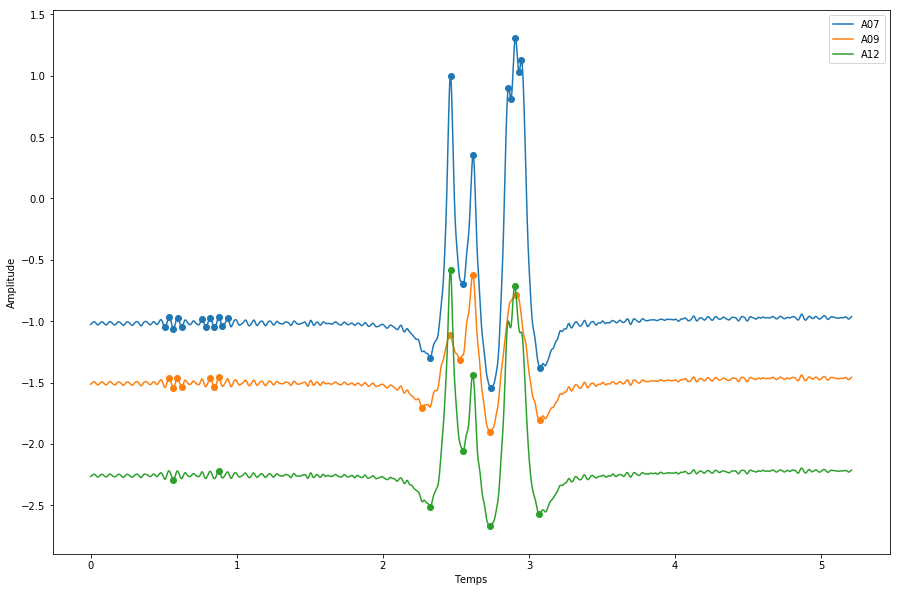

In [334]:
plt.figure(figsize=(15, 10))

# Courbe de capteurs
plt.plot(test.iloc[:,0], test.iloc[:, 1])
plt.plot(test.iloc[:,0], test.iloc[:, 2])
plt.plot(test.iloc[:,0], test.iloc[:, 3])

# Detections des maximas et minimas
plt.scatter(np.array(points1[0] + points1[1]).T[0], np.array(points1[0] + points1[1]).T[1])
plt.scatter(np.array(points2[0] + points2[1]).T[0], np.array(points2[0] + points2[1]).T[1])
plt.scatter(np.array(points3[0] + points3[1]).T[0], np.array(points3[0] + points3[1]).T[1])

plt.legend(['A07', 'A09','A12'])
plt.xlabel("Temps")
plt.ylabel("Amplitude")

plt.show()

In [72]:
np.array(points[0] + points[1]).T

array([[ 0.537109 ,  0.595703 ,  0.648438 ,  0.876953 ,  0.992188 ,
         1.11719  ,  1.22461  ,  1.27539  ,  1.39258  ,  1.50781  ,
         1.67578  ,  2.46289  ,  2.61719  ,  2.90625  ,  3.38086  ,
         3.77734  ,  3.9043   ,  4.12695  ,  4.27734  ,  4.51562  ,
         4.7207   ,  5.01953  ,  5.07227  ,  0.345703 ,  0.566406 ,
         0.623047 ,  0.847656 ,  0.960938 ,  1.08594  ,  1.19727  ,
         1.25391  ,  1.37109  ,  1.48633  ,  1.52734  ,  2.32422  ,
         2.55078  ,  2.73828  ,  3.07617  ,  3.40234  ,  3.80664  ,
         4.02344  ,  4.14844  ,  4.49219  ,  4.55273  ,  4.89258  ,
         5.04688  ],
       [ 0.0509951,  0.0457463,  0.0283976,  0.051064 ,  0.0305597,
         0.0266778,  0.0185338,  0.0168383,  0.0193803,  0.0244538,
         0.0122837,  2.0177   ,  1.36956  ,  2.32588  ,  0.0239185,
         0.0376298,  0.0349251,  0.0598934,  0.0561291,  0.0552014,
         0.0575895,  0.0635381,  0.0552237, -0.0198834, -0.0429974,
        -0.0309285, -0.0318